In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockdataset/FPT.csv
/kaggle/input/stockdataset/VIC.csv
/kaggle/input/stockdataset/PNJ.csv
/kaggle/input/stockdataset/MSN.csv


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.regularizers import l1_l2
from datetime import datetime
import yfinance as yf
import numpy as np
import random
import tensorflow as tf
import os

In [9]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.mixed_precision.set_global_policy('float32')

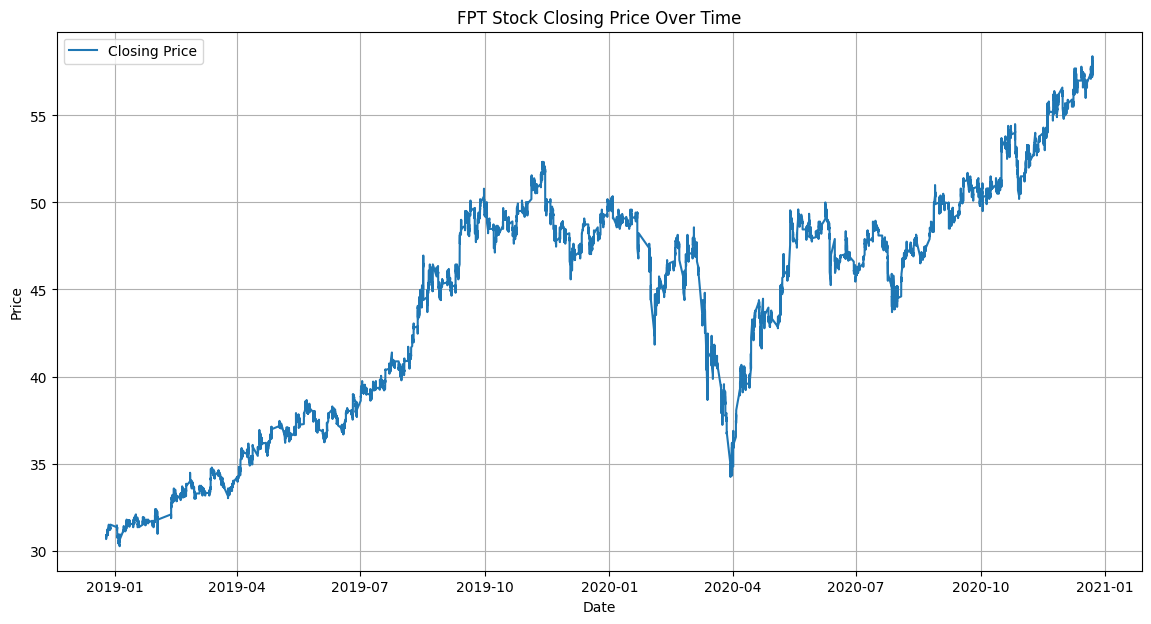

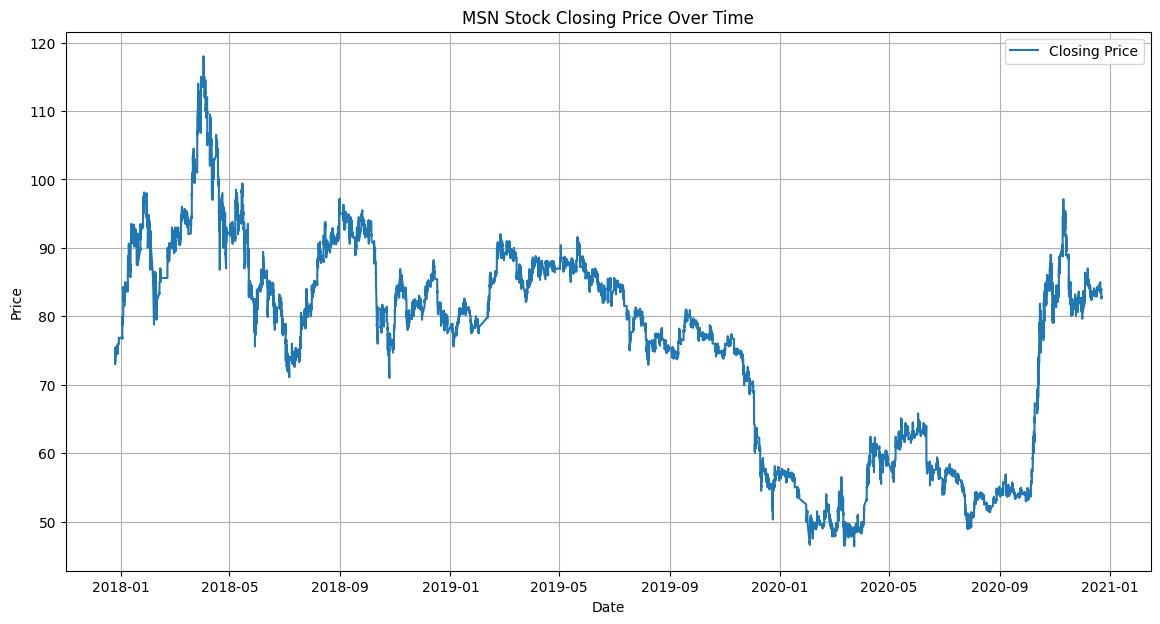

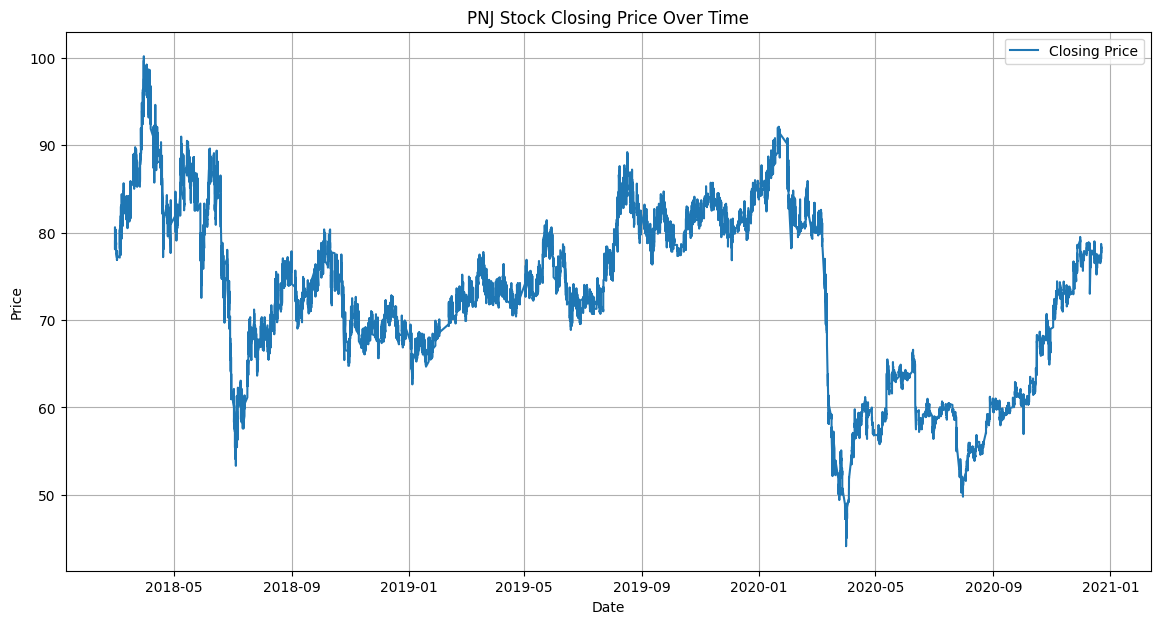

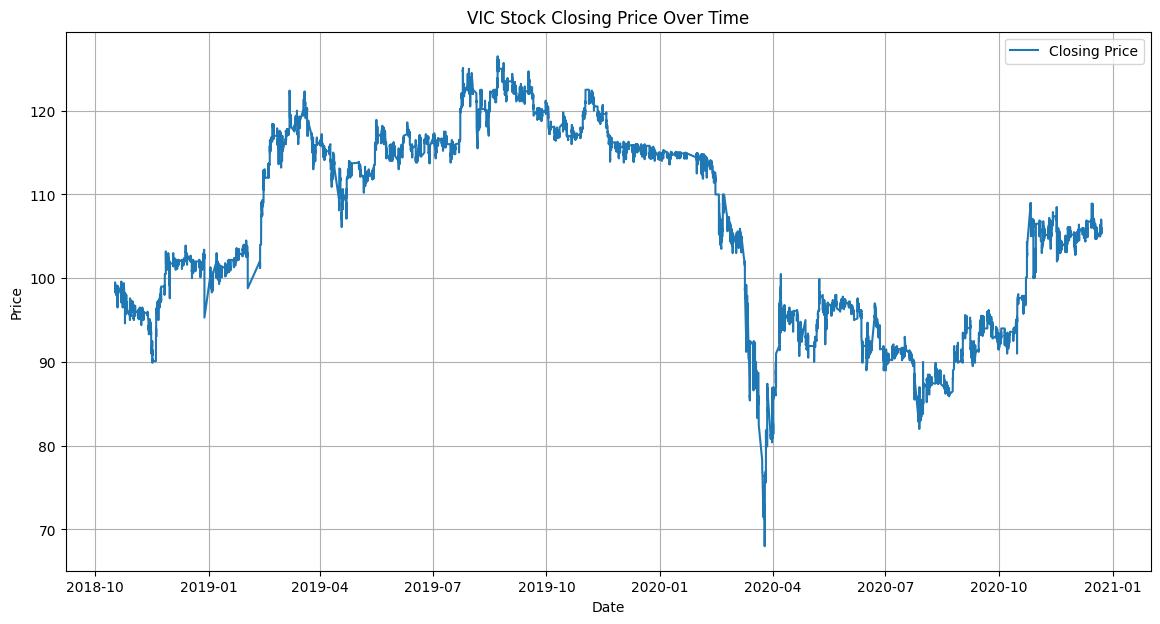

In [10]:
def load_and_preprocess_stock_data(file_path, plot=True):
    """
    Load and preprocess stock data from a CSV file.
    
    Parameters:
    -----------
    file_path : str
        Full path to the CSV file containing stock data
    plot : bool, optional
        Whether to create and display a closing price plot (default is True)
    
    Returns:
    --------
    pandas.DataFrame
        Preprocessed stock price DataFrame
    """
    # Read data
    df = pd.read_csv(file_path, parse_dates=['Date/Time'])
    df.set_index('Date/Time', inplace=True)

    # Handle columns
    df.columns = df.columns.get_level_values(0)
    df = df[['Open', 'Close', 'Volume', 'Low', 'High']]
    df.index.name = 'Date'  

    # Reset index to process dates
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Optional plotting
    if plot:
        plt.figure(figsize=(14, 7))
        plt.plot(df['Close'], label='Closing Price')
        plt.title(f'{file_path.split("/")[-1].split(".")[0]} Stock Closing Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    return df

df_FPT = load_and_preprocess_stock_data('/kaggle/input/stockdataset/FPT.csv')
df_MSN = load_and_preprocess_stock_data('/kaggle/input/stockdataset/MSN.csv')
df_PNJ = load_and_preprocess_stock_data('/kaggle/input/stockdataset/PNJ.csv')
df_VIC = load_and_preprocess_stock_data('/kaggle/input/stockdataset/VIC.csv')

In [11]:
# Hàm tính RSI (Relative Strength Index)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Hàm tính ATR (Average True Range)
def calculate_atr(df, window=14):
    high = df['High']
    low = df['Low']
    close = df['Close'].shift(1)
    
    tr1 = high - low
    tr2 = abs(high - close)
    tr3 = abs(low - close)
    
    tr = pd.DataFrame({'TR1': tr1, 'TR2': tr2, 'TR3': tr3}).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

def add_technical_indicators(df, ma_windows=(5, 20), rsi_window=14, atr_window=14):
    df = df.copy()
    # Moving Averages
    for window in ma_windows:
        df[f'MA{window}'] = df['Close'].rolling(window=window).mean()
    
    # RSI
    df['RSI'] = calculate_rsi(df['Close'], rsi_window)
    
    # Returns
    df['Return'] = df['Close'].pct_change()
    
    # ATR
    df['ATR'] = calculate_atr(df, atr_window)
    
    df.dropna(inplace=True)
    return df

In [12]:
# Kiểm tra xem GPU có sẵn không
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Cho phép tăng trưởng bộ nhớ (Memory Growth) để tránh lỗi bộ nhớ GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Memory growth enabled for GPUs


In [13]:
def scale_features(df, features):
    data = df[features].values
    scalers = {}
    scaled_data = np.zeros_like(data, dtype=np.float32)
    
    for i, feature in enumerate(features):
        if feature == 'Volume':
            scalers[feature] = RobustScaler()
        else:
            scalers[feature] = MinMaxScaler()
        
        scaled_data[:, i] = scalers[feature].fit_transform(data[:, i].reshape(-1, 1)).flatten()
    
    return scaled_data, scalers

def prepare_dataset(data):
    def create_dataset(_data, _time_step):
        X, y = [], []
        for i in range(len(_data) - _time_step - 1):
            X.append(_data[i:(i + _time_step), :])
            y.append(_data[i + _time_step, 0])
        return np.array(X), np.array(y)
    
    train_size = int(len(data) * 0.8)
    train_data, test_data = data[:train_size], data[train_size:]
    
    X_train, y_train = create_dataset(train_data, 20)
    X_test, y_test = create_dataset(test_data, 20)
    
    return (
        X_train.astype(np.float32), 
        y_train.astype(np.float32), 
        X_test.astype(np.float32), 
        y_test.astype(np.float32),
        test_data
    )

def build_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # CNN Layers
    model.add(Conv1D(32, 5, activation='relu', padding='same', 
                     input_shape=input_shape, kernel_regularizer=l1_l2(1e-5, 1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    model.add(Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l1_l2(1e-5, 1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    # LSTM Layers
    model.add(LSTM(64, return_sequences=True, activation='relu', 
                   recurrent_regularizer=l1_l2(1e-4, 1e-3), kernel_regularizer=l1_l2(1e-5, 1e-4)))
    model.add(Dropout(0.1))
    
    model.add(LSTM(32, return_sequences=False, activation='relu', 
                   recurrent_regularizer=l1_l2(1e-4, 1e-3), kernel_regularizer=l1_l2(1e-5, 1e-4)))
    model.add(Dropout(0.1))
    
    model.add(Dense(1))  # Output layer
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model




In [16]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Vẽ biểu đồ loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return history

def evaluate_model(model, X_test, y_test, scalers, df, test_data):
    # Predictions
    predicted = model.predict(X_test)
    predicted_prices = scalers['Close'].inverse_transform(predicted)
    y_test_actual = scalers['Close'].inverse_transform(y_test.reshape(-1, 1))
    
    mse = np.mean((predicted_prices - y_test_actual)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predicted_prices - y_test_actual))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Dự báo cho n ngày tiếp theo
    next_n = 90
    last_sequence = test_data[-20:].reshape(1, 20, len(features))
    
    predicted_next_n = []
    current_sequence = last_sequence.copy()
    
    for _ in range(next_n):
        # Dự đoán ngày tiếp theo
        next_day_pred = model.predict(current_sequence)
        predicted_next_n.append(next_day_pred[0, 0])
        
        # Tạo "giả định" cho các đặc trưng khác
        next_timestep = np.zeros((1, 1, len(features)))
        next_timestep[0, 0, 0] = next_day_pred[0, 0]  # Close price (dự đoán)
        
        # Giả định các giá trị khác dựa trên mối quan hệ lịch sử
        # Đây là một cách đơn giản để ước tính, có thể cải thiện trong tương lai
        last_known = current_sequence[0, -1, :]
        next_timestep[0, 0, 1] = last_known[1]  # Open ~ giữ nguyên
        next_timestep[0, 0, 2] = max(last_known[2], next_day_pred[0, 0] * 1.01)  # High ~ Close * 1.01
        next_timestep[0, 0, 3] = min(last_known[3], next_day_pred[0, 0] * 0.99)  # Low ~ Close * 0.99
        next_timestep[0, 0, 4] = last_known[4]  # Volume ~ giữ nguyên
        
        # MA5, MA20, RSI, Return và ATR cũng cần được ước tính một cách hợp lý
        next_timestep[0, 0, 5:] = last_known[5:]  # Giữ các chỉ báo kỹ thuật không đổi trong dự đoán
        
        # Cập nhật chuỗi cho lần dự đoán tiếp theo
        current_sequence = np.append(current_sequence[:, 1:, :], next_timestep, axis=1)
    
    # Chuyển đổi dự đoán về thang đo ban đầu
    predicted_next_n = np.array(predicted_next_n).reshape(-1, 1)
    predicted_next_n = scalers['Close'].inverse_transform(predicted_next_n)

    
    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual')
    plt.plot(df.index[-len(predicted_prices):], predicted_prices, label='Predicted')
    plt.title('Actual vs Predicted Prices')
    # Xử lý giá trị dự báo để đảm bảo không âm
    predicted_next_n[predicted_next_n < 0] = 0
    
    # Vẽ giá dự báo
    forecast_dates = pd.date_range(df.index[-1], periods=next_n+1, freq='D')[1:]  # Tạo ngày cho dự báo
    plt.scatter(forecast_dates, predicted_next_n, label=f'Forecasted Prices (Next {next_n} Days)', color='lime', s=20, alpha=0.7)
    plt.plot(forecast_dates, predicted_next_n, color='green', linestyle='-', linewidth=2)
    
    # Tùy chỉnh biểu đồ
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    # Lưu biểu đồ ở 300 dpi
    plt.savefig('FPT_improved_cnn_lstm_forecast.png', dpi=300)
    
    # Hiển thị biểu đồ
    plt.show()

    
    return predicted_prices, y_test_actual


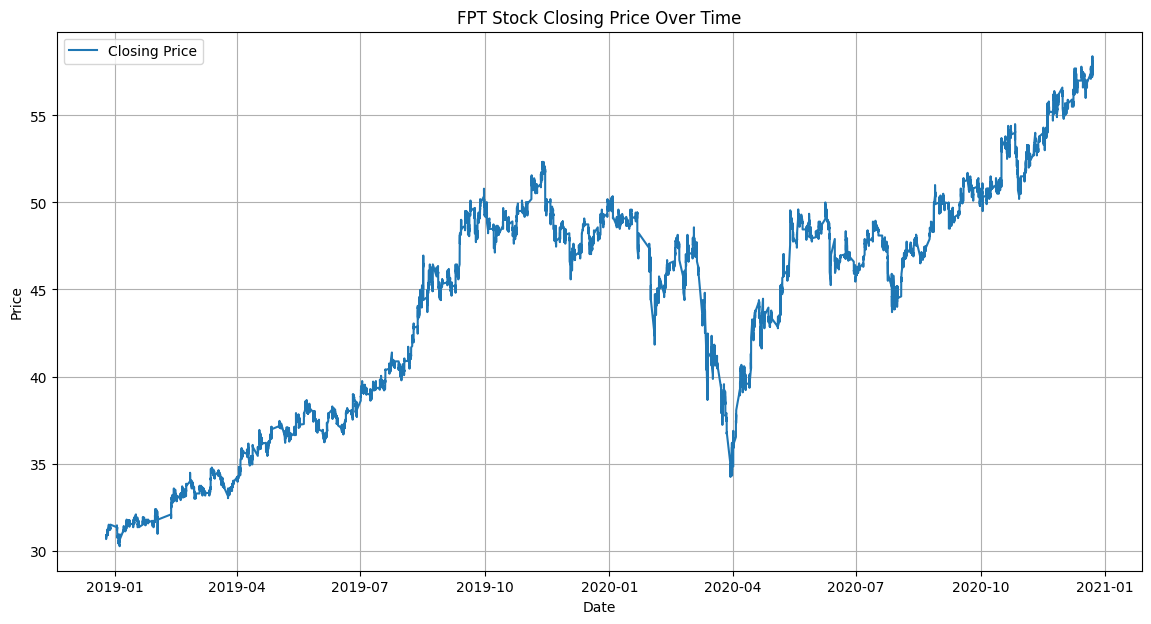

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.1183 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 2/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0258 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 3/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0137 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 4/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0078 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 5/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0048 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 6/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0032 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 7/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0021 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 9/150
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0018 - val_loss: 0.0028 - lear

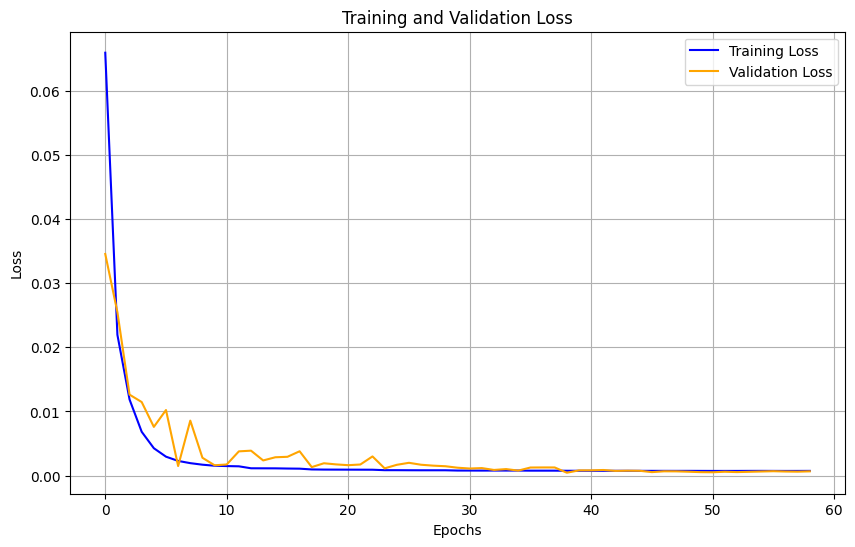

604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Root Mean Squared Error (RMSE): 0.4629407823085785
Mean Absolute Error (MAE): 0.41047683358192444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

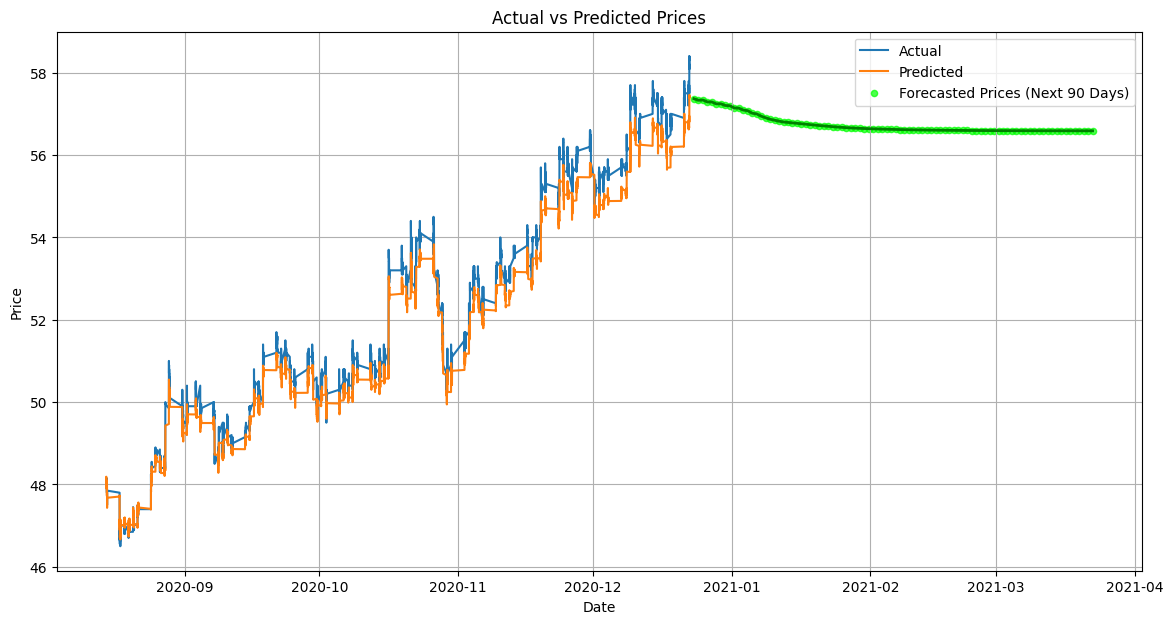

In [17]:
if __name__ == "__main__":
    set_seeds()
    
    # 1. Load data
    df = load_and_preprocess_stock_data('/kaggle/input/stockdataset/FPT.csv')
    
    # 2. Add technical indicators
    df = add_technical_indicators(df)
    
    # 3. Select features and scale
    features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA5', 'MA20', 'RSI', 'Return', 'ATR']
    scaled_data, scalers = scale_features(df, features)
    
    # 4. Prepare datasets
    X_train, y_train, X_test, y_test, test_data = prepare_dataset(scaled_data)
    
    # 5. Build and train model
    model = build_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    
    # 6. Evaluate
    predicted, actual = evaluate_model(model, X_test, y_test, scalers, df, test_data)
    

    
    # 8. Save model
    model.save('stock_forecast_model.h5')

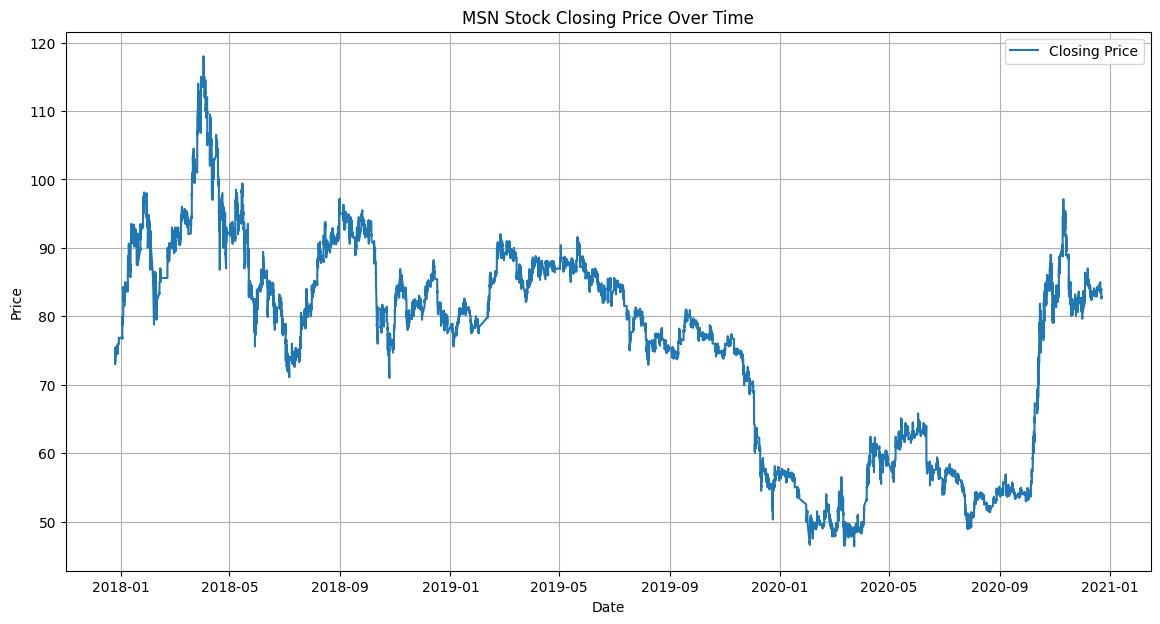

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1008 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 2/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0152 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 3/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0064 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0033 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0024 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 6/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0021 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 8/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0020 - val_loss: 9.5282e-04 - learning_rate: 0.0010
Epoch 9/150
1683/1683 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0020 - val_loss: 0.0018 - 

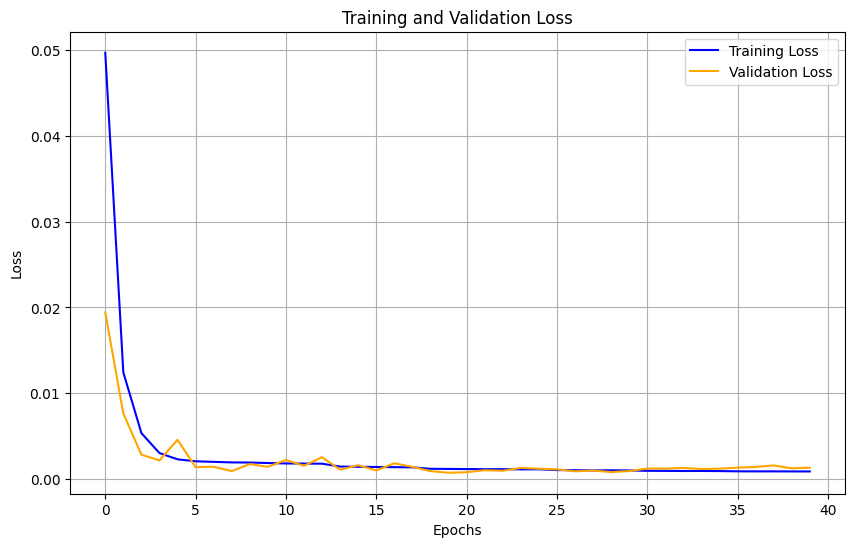

841/841 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Root Mean Squared Error (RMSE): 1.4205580949783325
Mean Absolute Error (MAE): 1.1669576168060303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

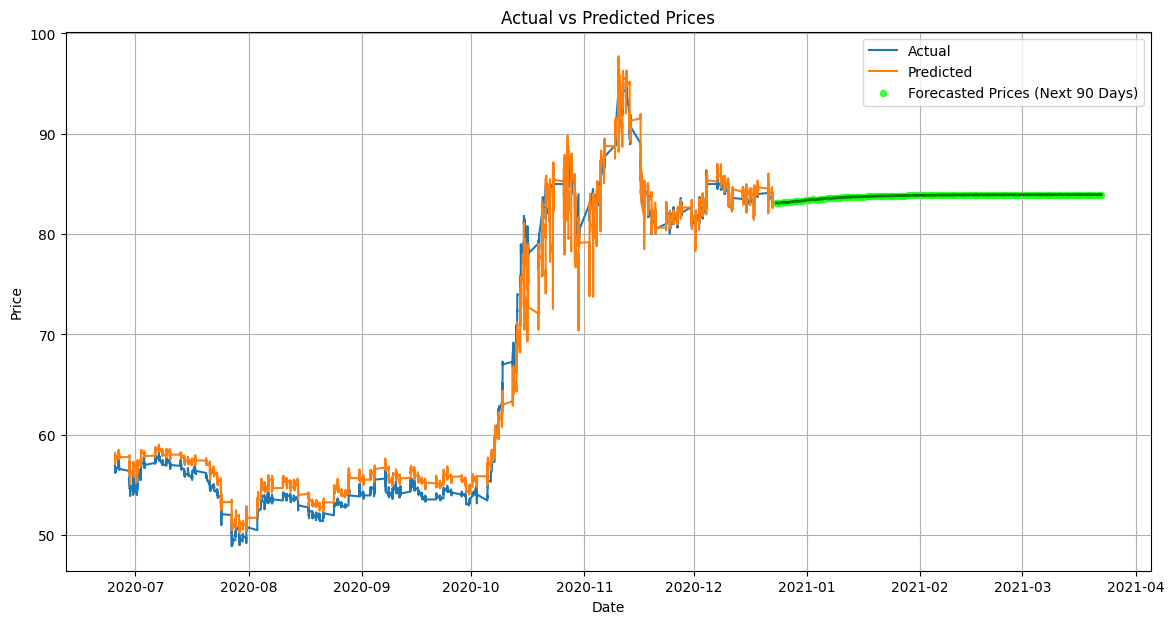

In [18]:
MSN_df = load_and_preprocess_stock_data('/kaggle/input/stockdataset/MSN.csv')
MSN_df = add_technical_indicators(MSN_df)
MSN_scaled_data, MSN_scalers = scale_features(MSN_df, features)

# Huấn luyện mô hình mới
X_train_MSN, y_train_MSN, X_test_MSN, y_test_MSN, MSN_test_data = prepare_dataset(MSN_scaled_data)
MSN_model = build_cnn_lstm_model((X_train_MSN.shape[1], X_train_MSN.shape[2]))
MSN_history = train_and_evaluate_model(MSN_model, X_train_MSN, y_train_MSN, X_test_MSN, y_test_MSN)
predicted, actual = evaluate_model(MSN_model, X_test_MSN, y_test_MSN, MSN_scalers, MSN_df, MSN_test_data)
model.save('stock_forecast_model.h5')

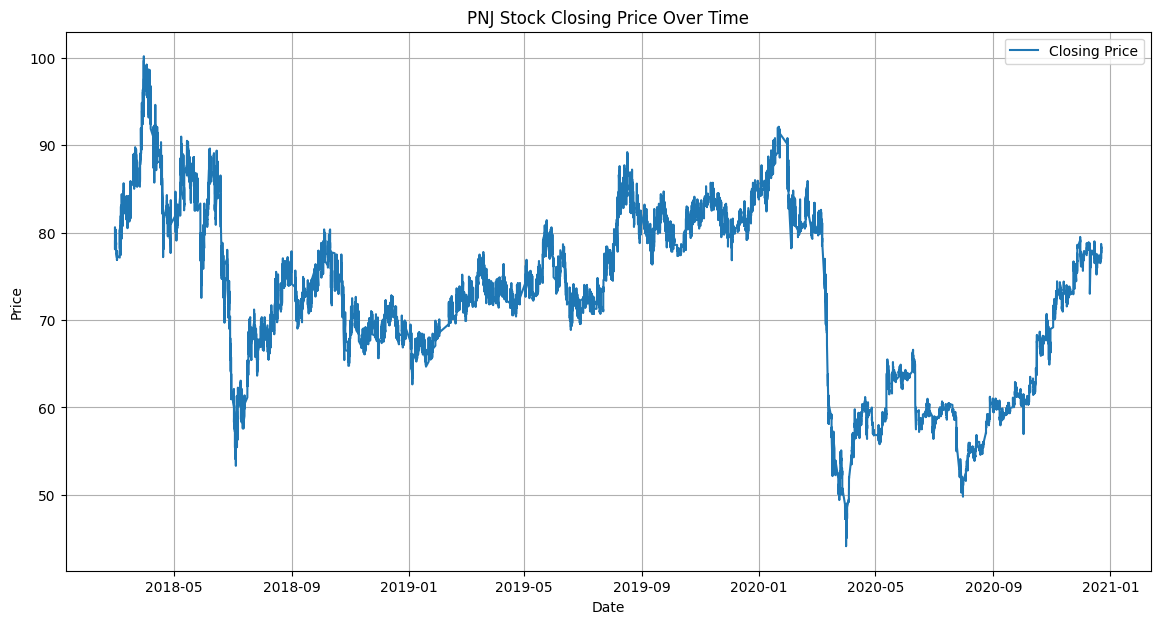

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0828 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 2/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0086 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 3/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0032 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0022 - val_loss: 9.2764e-04 - learning_rate: 0.0010
Epoch 5/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0019 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 6/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0017 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0017 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 8/150
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 9/150
1550/1557 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 9: ReduceLROnPl

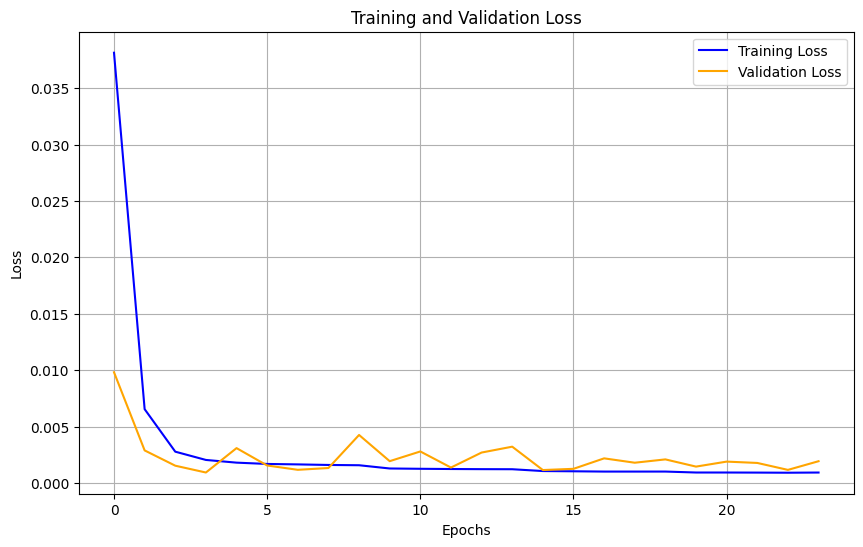

778/778 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Root Mean Squared Error (RMSE): 0.8336895108222961
Mean Absolute Error (MAE): 0.6538485288619995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

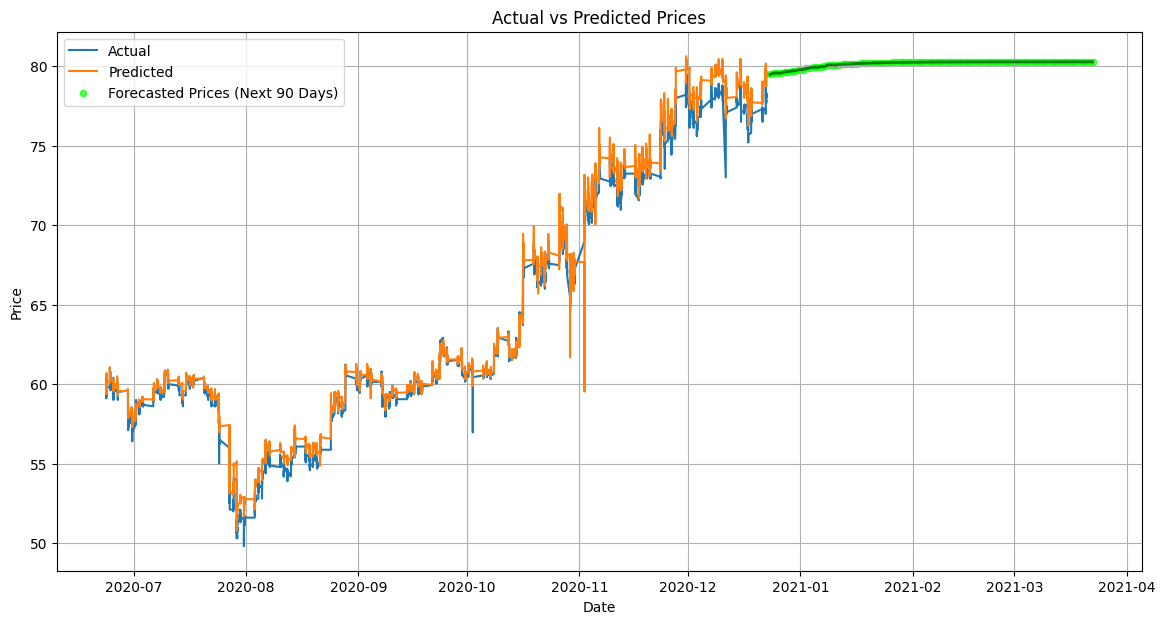

In [19]:
PNJ_df = load_and_preprocess_stock_data('/kaggle/input/stockdataset/PNJ.csv')
PNJ_df = add_technical_indicators(PNJ_df)
PNJ_scaled_data, PNJ_scalers = scale_features(PNJ_df, features)

# Huấn luyện mô hình mới
X_train_PNJ, y_train_PNJ, X_test_PNJ, y_test_PNJ, PNJ_test_data = prepare_dataset(PNJ_scaled_data)
PNJ_model = build_cnn_lstm_model((X_train_PNJ.shape[1], X_train_PNJ.shape[2]))
PNJ_history = train_and_evaluate_model(PNJ_model, X_train_PNJ, y_train_PNJ, X_test_PNJ, y_test_PNJ)
predicted, actual = evaluate_model(PNJ_model, X_test_PNJ, y_test_PNJ, PNJ_scalers, PNJ_df, PNJ_test_data)
model.save('stock_forecast_model.h5')

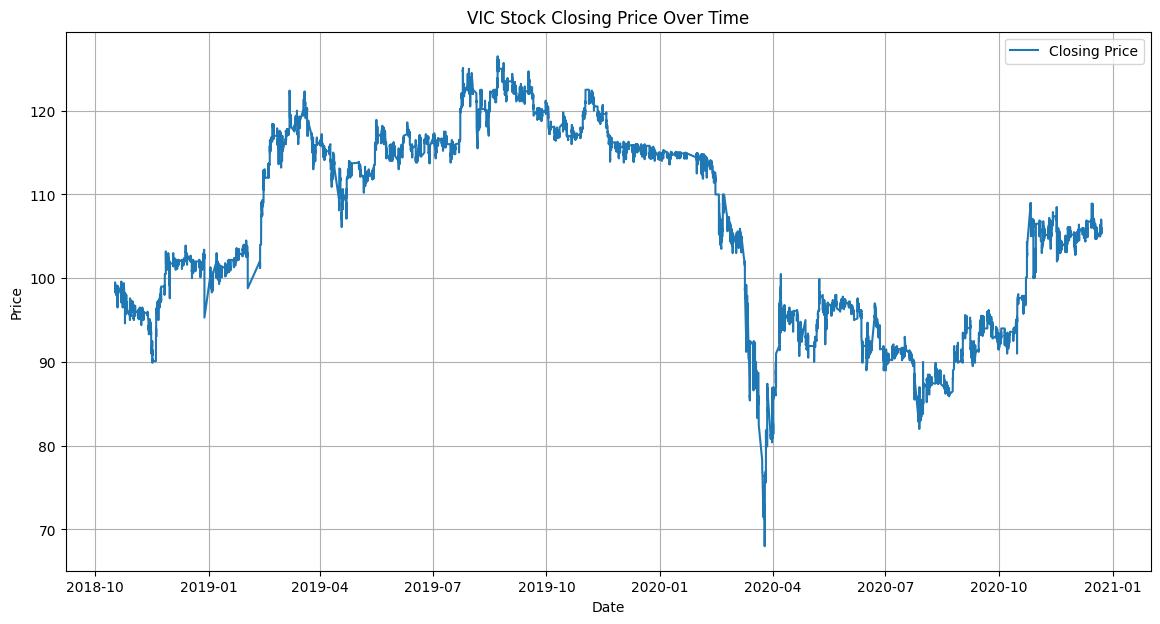

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.1302 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 2/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0232 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 3/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0117 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 4/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0060 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 5/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0034 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0025 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 7/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0020 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0019 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 9/150
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0018 - val_loss: 0.0018 - lear

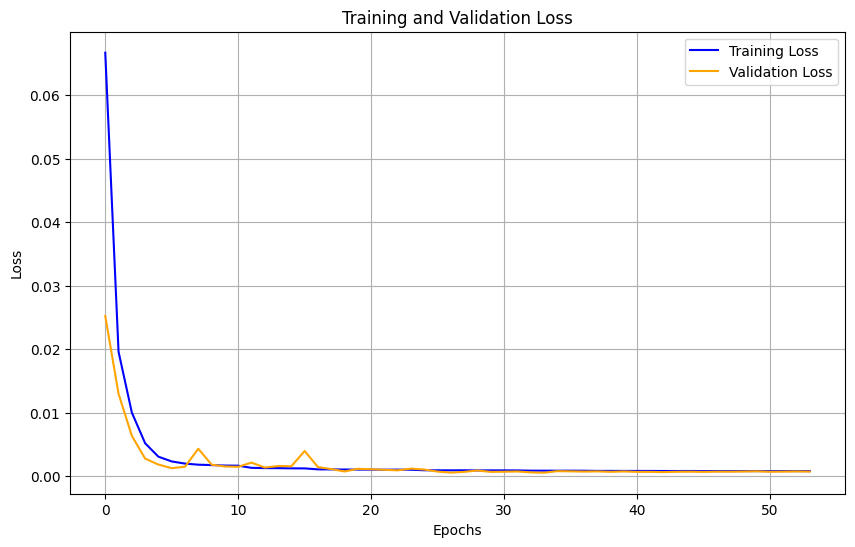

629/629 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Root Mean Squared Error (RMSE): 1.0226091146469116
Mean Absolute Error (MAE): 0.7879623174667358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

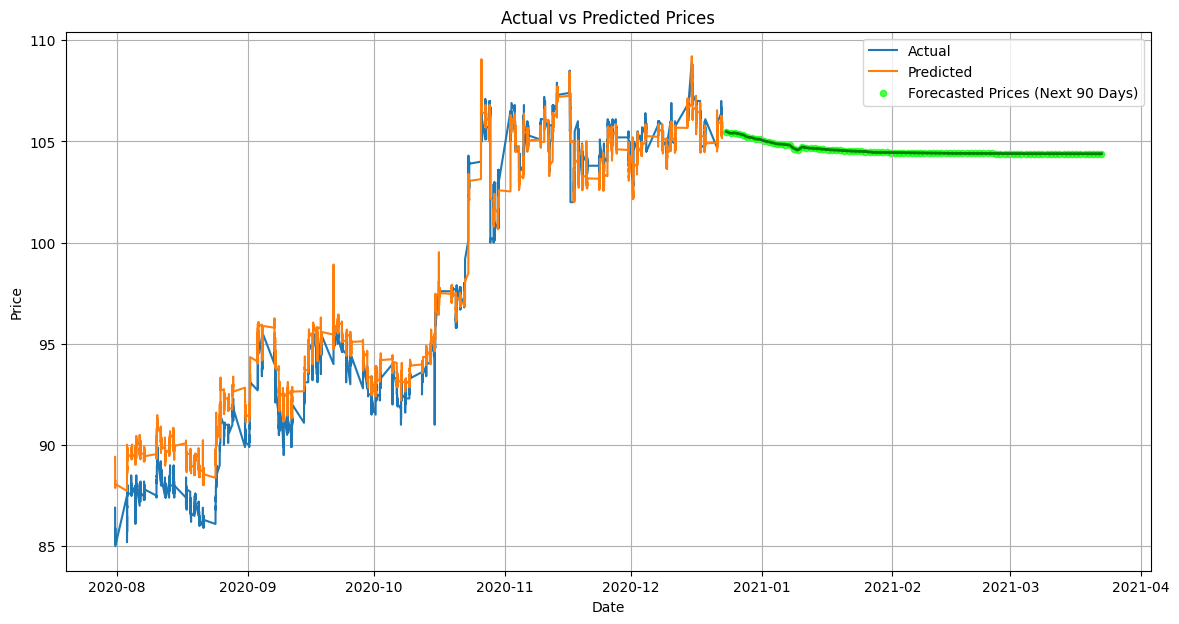

In [20]:
VIC_df = load_and_preprocess_stock_data('/kaggle/input/stockdataset/VIC.csv')
VIC_df = add_technical_indicators(VIC_df)
VIC_scaled_data, VIC_scalers = scale_features(VIC_df, features)

# Huấn luyện mô hình mới
X_train_VIC, y_train_VIC, X_test_VIC, y_test_VIC, VIC_test_data = prepare_dataset(VIC_scaled_data)
VIC_model = build_cnn_lstm_model((X_train_VIC.shape[1], X_train_VIC.shape[2]))
VIC_history = train_and_evaluate_model(VIC_model, X_train_VIC, y_train_VIC, X_test_VIC, y_test_VIC)
predicted, actual = evaluate_model(VIC_model, X_test_VIC, y_test_VIC, VIC_scalers, VIC_df, VIC_test_data)
model.save('stock_forecast_model.h5')